In [338]:
import numpy as np
import qinfer as qi
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline
%run mfl_sensing_simplelib.py
print("Hello")

Hello


# Preliminaries for the run

## Common parameters

In [353]:
%run mfl_sensing_simplelib.py

def set_common_params():
    global true_omega, freq_min, freq_max, prior
    global t2star_s, true_params, n_particles
    global mfl_res_a, mfl_res_th
    global noise_mode, noise_c, noise_n_rep

    true_omega = 2*np.pi*0.5   # MHz rad

    # the frequency boundaries for the starting prior
    freq_min = 0
    freq_max = 2*np.pi*5 # MHz
 
    t2star_s = 10e-6  # s
    true_params = np.array([[true_omega]])

    # mfl params
    n_particles = 1000
    mfl_res_a = 0.98
    mfl_res_th = 0.5

    # noise
    noise_mode = None
    noise_c = 0.03
    noise_n_rep = 1e3

set_common_params()


<Figure size 432x288 with 0 Axes>

## MFL Lib

In [445]:
%run mfl_sensing_simplelib.py

def reset_result():
    global track_eval, track_cov, track_tau, track_priors, track_errors, track_z
    global prior, model, updater, from_heuristic
    global mfl_res_a, mfl_res_th
    
    track_eval = [] # MHz rad
    track_cov = []  # MHz rad
    track_tau = []  # ns
    track_z = [] # elements: (noisy val, real val, is_error)
    track_priors = [] # elements: (prior_as_array, idx_epoch)
    
    #model = ExpDecoKnownPrecessionModel(min_freq= freq_min, invT2= 1/(t2star_s*1e6))
    # resetting updater&heuristic for ease of multiple calls to this cell
    #updater = basic_SMCUpdater(model, n_particles, prior, resample_a=mfl_res_a, resample_thresh=mfl_res_th)
    #updater.reset()
    #heuristic = stdPGH(updater, inv_field='w_')

def get_params():
    global mfl_res_a, mfl_res_th
    global true_omega, freq_min, freq_max, prior
    global t2star_s, true_params, n_particles
    global noise_mode, noise_c, noise_n_rep
    
    ret_dict = {'mfl_res_a': mfl_res_a, 'mfl_res_th':mfl_res_th,
               'true_oemga': true_omega, 'freq_min': freq_min,'freq_max': freq_max,
                't2star_s': t2star_s, 'n_particles':n_particles,
                'noise_mode': noise_mode, 'noise_c': noise_c, 'noise_n_rep': noise_n_rep}
    
    return ret_dict
    
def DEBUG_rand_z():
    import random
    return random.randint(0,1)

def plot_current_prior(label=None):
    #global prior, model, updater, from_heuristic
    # all particles
    #x = np.asarray(updater.particle_locations)
    #y = np.asarray(updater.particle_weights)
    #plt.scatter(x, updater.particle_weights, label=label)
    #plt.ylim(0, np.max(updater.particle_weights))
    #plt.legend()
    #plt.show()
    
    prior_arr = get_current_prior()
    plot_hist(prior_arr, label=label)

def plot_hist(data, label=None, n_bins=15, color=None):
    plt.hist(data, label=label, bins=n_bins, color=color)
    plt.legend()

    
def get_current_prior():
    global prior, model, updater, from_heuristic
    return updater.sample(n=updater.n_particles)

def majority_vote(z, z_thres=0.5):
    if z > z_thres:
        return 1
    else:
        return 0

def exp_result(model, true_params, experiment, n_sweeps=1):
    res_list = []
    # todo: n_sweeps like this shouldn't make any difference for ideal case!
    if n_sweeps > 1:
        raise RuntimeError("Shouldn't use this anymore. No difference for ideal case. Noise handled differently!")
    for i in range(0, n_sweeps):
        res_no_noise = []
        res_list.append(model.simulate_experiment(true_params, experiment, res_no_noise=res_no_noise, full_result=True))
        if len(res_no_noise) > 0:
            z_real = res_no_noise[0]
        else:
            z_real = None
    
    avg = np.average(np.asarray(res_list))
    #print("debug: ramsey: average {} of n_sweeps= {}".format(avg, n_sweeps))
    return avg, z_real

def run_estimation(n_epochs=25, n_sweeps=1):
    global prior, model, updater, from_heuristic
    global noise_mode, noise_c, noise_n_rep
    
    true_params = np.array([[true_omega]])
    # the expected T2*, when 0 this is the ideal case
    if t2star_s != 0.:
        inv_T2 = 1/(1e6*t2star_s)
    else:
        inv_T2 = 0
    
    prior = qi.UniformDistribution([freq_min, freq_max])
    
    if noise_mode is None:
        model = ExpDecoKnownPrecessionModel(min_freq=freq_min, invT2= inv_T2)
    #model = NoisyExpDecoKnownPrecessionModel(min_freq=freq_min, invT2= inv_T2, eta=1.0, noise='Unbalanced').get_model()
    elif noise_mode is 'Gauss':
        model = NoisyGaussianExpDecoKnownPrecessionModel(min_freq=freq_min, invT2=inv_T2, c_eff=noise_c, n_rep=noise_n_rep)
    else:
        raise RuntimeError("Invalid noise mode: {}".format(noise_mode))
    
    # resetting updater&heuristic for ease of multiple calls to this cell
    updater = basic_SMCUpdater(model, n_particles, prior, resample_a=mfl_res_a, resample_thresh=mfl_res_th)
    heuristic = stdPGH(updater, inv_field='w_')
    
    #rint("DEBUG: Running mfl with: {}".format(get_params()))
          
    for idx_epoch in range(n_epochs):
        #  we call the heuristic to generate a time
        experiment = heuristic()
        tau = experiment['t']

        track_priors.append((get_current_prior(), idx_epoch))
        #plot_current_prior(label='Prior epoch {}'.format(idx_epoch))
            
        # we extract a datum calling the actual system, here we are simulating this, 
        # but in the experiment will be replaced by a call to the actual NV centre system
        datum, datum_no_noise = exp_result(model, true_params, experiment, n_sweeps=n_sweeps)
        datum_bin, datum_no_noise_bin = majority_vote(datum), majority_vote(datum_no_noise)
        is_error = (datum_bin != datum_no_noise_bin)
        track_z.append([datum, datum_no_noise, is_error])
          
        # we invoke the updater method to update the estimate according to the last datum and time chosen
        #experiment['w_'] = 0 # debug: 2nd element needed?
        updater.update(datum_bin, experiment)
            
        # here we just append our latest estimate and error estimate to the list of estimates
        track_tau.append(tau*1e3) # us -> ns
        track_eval.append(float(updater.est_mean()[0]))  # MHz rad
        track_cov.append( np.sqrt( updater.est_covariance_mtx() )  )
    
    return (track_tau, track_eval, track_cov, track_priors)

def plot_result():
    #print(track_eval[-1], track_cov[-1])
    
    # est(B), dB
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(np.asarray(track_eval)/(2.*np.pi), label='est(B)= {:.4f} MHz'.format(track_eval[-1]/(2*np.pi)))
    plt.plot(np.asarray([el[0][0] for el in track_cov])/(2*np.pi), label='dB')
    plt.axhline(y=true_omega/(2*np.pi), label="B= {:.1f} MHz".format(true_omega/(2*np.pi)))
    plt.legend()
    axes = plt.gca()
    axes.set_ylabel('B*gamma / dB (MHz)')
    
    plt.show()
    
def plot_priors(epochs_idx=[], n_bins=15):
    
    plot_all = not epochs_idx 
    epochs_error = [el[0] for el in get_error_zs()]
    n_plots = len(track_priors) if plot_all else len(epochs_idx)
    n_plots += len(epochs_error)
    n_rows = np.ceil(n_plots/5)    
    plt.figure(figsize=(12, n_rows*4))
    
    idx_plot = 0
    for i, p in enumerate(track_priors):
        epoch = p[1]
        is_error = epoch in epochs_error
        color = 'blue' if not is_error else 'red'
        
        if epoch in epochs_idx or plot_all or is_error:
            data = np.asarray(p[0])/(2*np.pi)
            plt.subplot(n_rows, 5, idx_plot+1)
            plot_hist(data, label='Prior epoch {}'.format(epoch), n_bins=n_bins, color=color) 
            plt.xlabel("B (MHz)")
            plt.tight_layout()
            idx_plot += 1
    
    plt.show()
    
def plot_taus():
  # tau
    taus = np.asarray(track_tau)  # ns
    t2_ns = t2star_s*1e9
    tau_median_ns = np.median(taus)
    frac_bigger_t2 = len(taus[taus>t2_ns])/len(taus)
    frac_bigger_10t2 = len(taus[taus>10*t2_ns])/len(taus)
    taus_filter_ns = taus[taus < 10 *t2_ns]
    
    plt.figure(figsize=(12, 1*4))
    plt.subplot(121)
    plt.semilogy(taus*1e-3, label='tau')
    plt.legend()

    plt.axhline(y=t2_ns*1e-3, label='T2*= {} us'.format(t2_ns*1e-3), color='red')
    plt.axhline(y=tau_median_ns*1e-3, label='median= {:.1f} us'.format(tau_median_ns*1e-3), color='green')
    axes = plt.gca()
    axes.set_ylim([0.01,1000])
    axes.set_xlabel('epoch')
    axes.set_ylabel('tau (us)')
    axes.set_title('frac_bigger_t2= {}, bigger_10*t2= {}'.format(frac_bigger_t2, frac_bigger_10t2))
    plt.legend()
    
    plt.subplot(122)
    plt.hist(taus_filter_ns*1e-3, bins=100)
    axes = plt.gca()
    axes.set_xlim([0,4*t2_ns*1e-3])
    axes.set_xlabel('tau (us)')
    axes.set_ylabel('histogram')
    plt.axvline(tau_median_ns*1e-3, label='median= {:.1f} us'.format(tau_median_ns*1e-3), color='green')
    plt.axvline(x=t2_ns*1e-3, label='T2*= {} us'.format(t2_ns*1e-3), color='red')
    #plt.axvline(t2_ns)
    plt.legend()
    plt.show()
    
def plot_noise_model(n_samples=1e3, n_bins=15):
    global noise_mode, noise_n_rep, noise_c
    
    if noise_mode == 'Gauss':
        res0 = np.random.normal(loc=0, scale=1./np.sqrt(4*noise_c**2 * noise_n_rep), size=int(n_samples))  
        res1 = np.random.normal(loc=1, scale=1./np.sqrt(4*noise_c**2 * noise_n_rep), size=int(n_samples))  
    elif noise_mode == None:
        res0 = [0]
        res1 = [1]
    else:
        raise NotImplementedError('Unknown noise model: {}'.format(noise_mode))
    plt.hist(res0, bins=n_bins)
    plt.hist(res1, bins=n_bins)
    plt.xlabel('sig_z')
    plt.title("Noise for 0/1 state. C= {}, n_sweeps= {}".format(noise_c, noise_n_rep))
    plt.hist(np.concatenate([res0, res1]), histtype='step', bins=n_bins)
    plt.axvline(0, color='blue')
    plt.axvline(1, color='orange')
    
    plt.show()
    
def get_error_zs():
    # [i_epoch, (track_z)]
    return [[i, el[0], el[1], el[2]] for i, el in enumerate(track_z) if el[2]]
#run_estimation()
#noise_mode = 'Gauss'
#noise_n_rep = 1e3
#noise_c = 0.03
#plot_noise_model()
    

# Run MFL

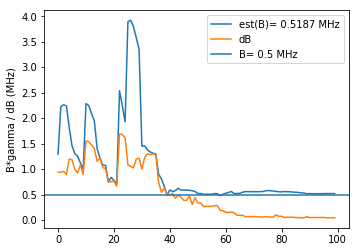

rel error= 3.75%. Error datums: 35 (35.0 %)


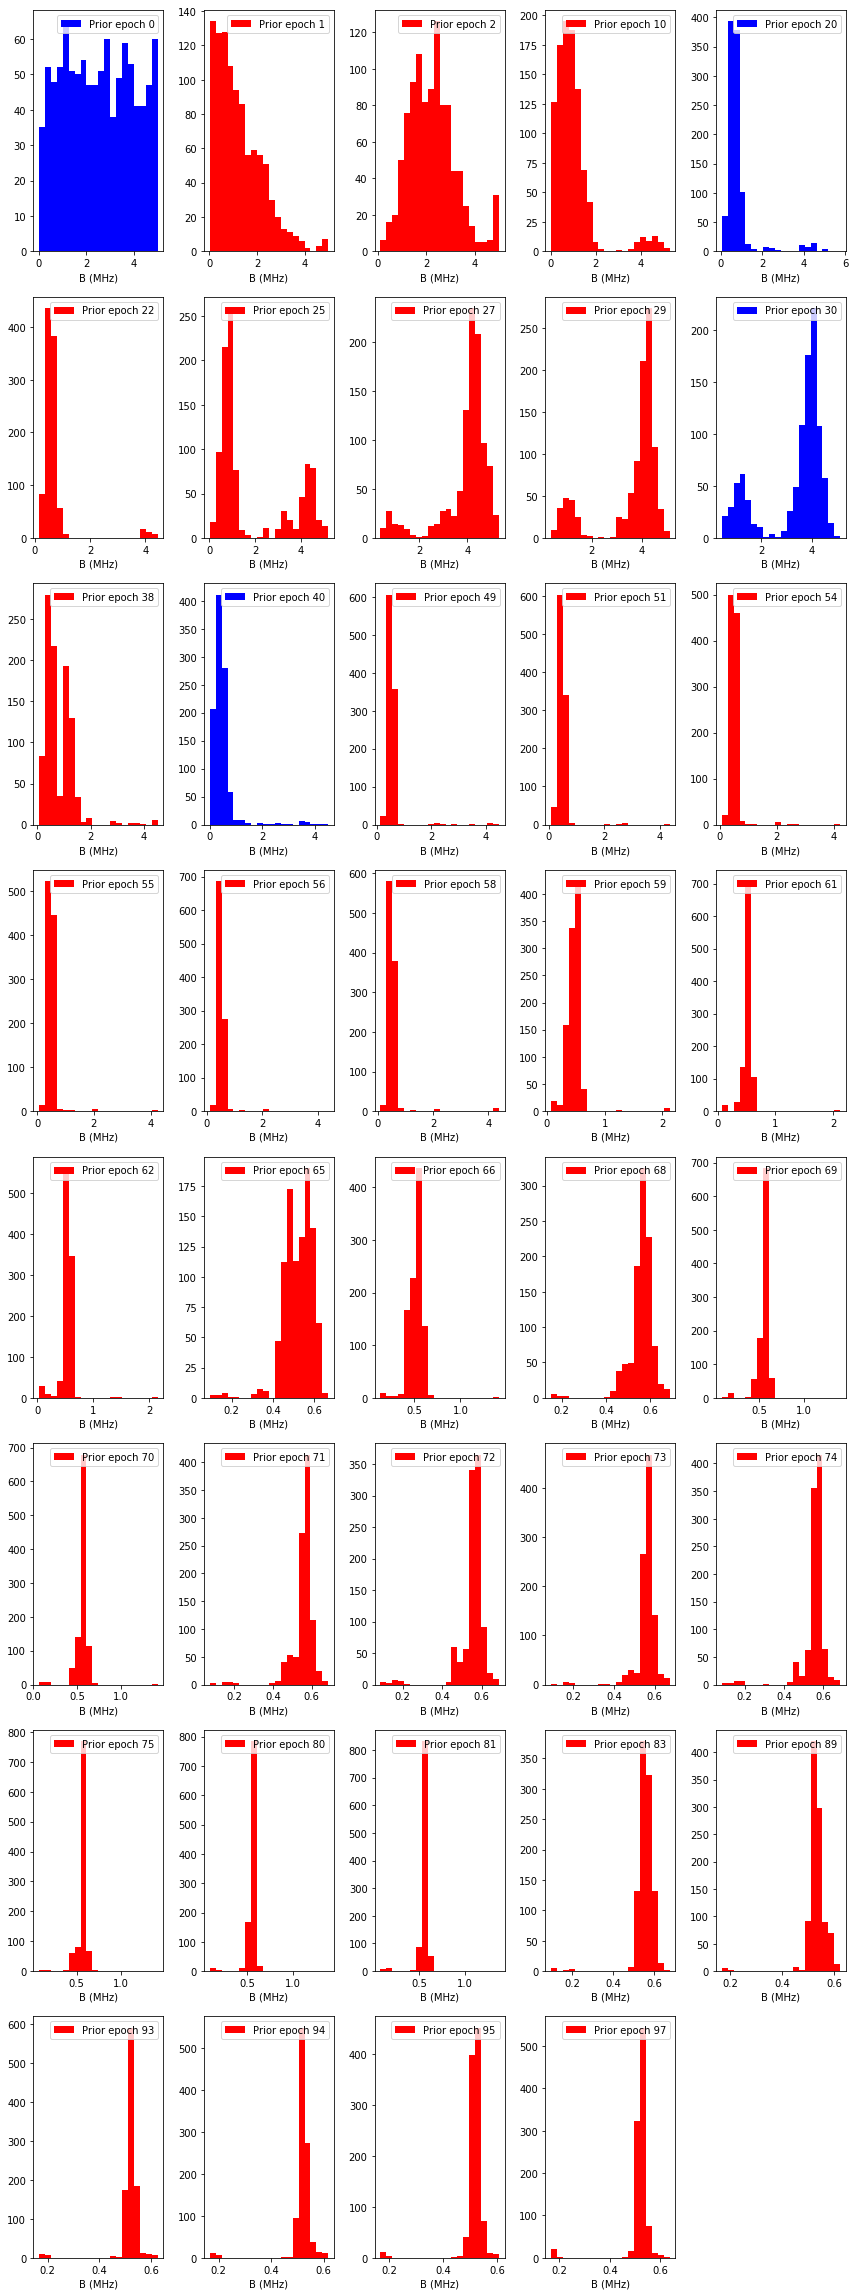

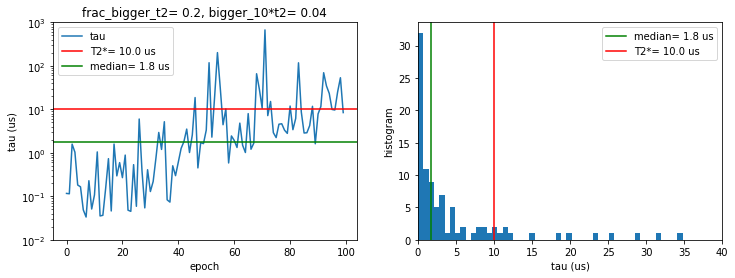

In [447]:
# run MFL
set_common_params()
reset_result()
n_epochs = 100
noise_mode = 'Gauss'
noise_c = 0.03
noise_n_rep = 1e3

#run_estimation(n_epochs=n_epochs, n_sweeps=1)
run_estimation(n_epochs=n_epochs, n_sweeps=1)
plot_result()
errs = get_error_zs()
print("rel error= {:.2f}%. Error datums: {} ({:.1f} %)".format(
    100*(track_eval[-1]-true_omega)/true_omega,len(errs), len(errs)/n_epochs*100))
#print("in (epoch, val, val_noNoise): {}".format(errs))
#plot_noise_model()
plot_priors(epochs_idx=range(0, n_epochs//2, 10), n_bins=20)
plot_taus()

#reset_result()
#run_estimation(n_epochs=n_epochs, n_sweeps=1, ret_priors_list=[0, n_epochs/2, n_epochs-1])
#plot_result()
#plot_priors(n_bins=20)

## Create tau list

4 reps with 150 epochs
[298, 379, 398, 406, 412, 434, 443, 447, 454, 464, 527, 531, 536, 553, 559, 592, 597, 648, 667, 768, 797, 815, 848, 855, 860, 866, 871, 873, 904, 937, 958, 976, 982, 1029, 1051, 1153, 1161, 1238, 1415, 1447, 1514, 1517, 1550, 1573, 1847, 1928, 2236, 2316, 2348, 2531, 2577, 2852, 3290, 3321, 3492, 3587, 3595, 3658, 3665, 3666, 3727, 3749, 3792, 3870, 4147, 4316, 4384, 4722, 4740, 4984, 5091, 5196, 5208, 5220, 5306, 5654, 5767, 6156, 6361, 6384, 6513, 6533, 6662, 6952, 7040, 7072, 7111, 7116, 7546, 7878, 8420, 8744, 8836, 8913, 8955, 9056, 9143, 9358, 9552, 9617, 9726, 9730, 9823, 9981, 10015, 10027, 10411, 10534, 10605, 10659, 10747, 10765, 10997, 11034, 11261, 11269, 11437, 11452, 11500, 11506, 11633, 11680, 11715, 11887, 12072, 12081, 12085, 12107, 12151, 12207, 12302, 12339, 12438, 12513, 12605, 12676, 12717, 12803, 12894, 12909, 13120, 13271, 13277, 13320, 13832, 13950, 14019, 14199, 14436, 14489, 14505, 14682, 14746, 14856, 14883, 15000, 15179, 15232, 15641, 

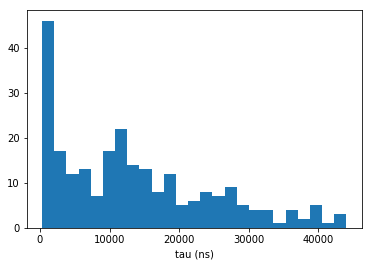

In [6]:
import random
import functools, operator
    
def create_tau_exp(n_taus_exp=245, n_epochs=150, tau_first_req_ns=25e-9):
    
    def flatten(a):
        # relatively inefficient like this
        #https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
        try:
            return list(np.asarray(a).flatten())
        except TypeError as e:
            print("Error in {}".format(a))
            raise e
        
    global t2star_s, track_tau
    
    t2_ns = t2star_s*1e9
    tau_filter_thresh = 3*t2_ns
    n_mc = (n_taus_exp // n_epochs + 1) * 2   # monte carlo repetitions
    print("{} reps with {} epochs".format(n_mc, n_epochs))
    tau_acc = [tau_first_req_ns*1e9]
    
    for i in range(0, n_mc):
        reset_result()
        run_estimation(n_epochs=n_epochs, n_sweeps=1, ret_priors_list=[])
        tau_acc.extend(flatten(track_tau))
        tau_acc = flatten(tau_acc)
        #print("track_tau {} {}".format(len(track_tau), track_tau))
        #print("tau_acc {} {}".format(len(tau_acc), tau_acc))
        #print("flatten track_tau {} {}".format(len(flatten(track_tau)), flatten(track_tau)))
        
 
    taus_filter_ns = np.asarray(list(map(int, tau_acc)))   # to array of ints
    taus_filter_ns = sorted(list(set(taus_filter_ns[taus_filter_ns < tau_filter_thresh])))  # remove duplicates and filter
    taus_exp = random.sample(taus_filter_ns, k=n_taus_exp)

    print((sorted(taus_exp)))
    plt.hist(taus_exp, bins=25)
    plt.xlabel("tau (ns)")
    
    return taus_exp

noise_mode = 'Gauss'
noise_c = 0.03
noise_n_rep = 3e3
tau_list = create_tau_exp()

# Sensitivity

In [449]:
# todo: currently broken 

## Monte carlo lib

In [342]:
## Monte Carlo sensitivity without overhead

t_overhead = {'comp':0.1e-3, 'latency':0e-6, 't_laser':3000e-9, 't_wait':1000e-9, 't_mw':50e-9}   # s

def sample_db_monte_carlo_mfl(n_mc, n_epochs, n_sweeps):
    """
    samples n_mc mfl runs and gives for each sample estimates after 
    one complete mfl run.
    """
    global true_omega
    global t_overhead_dict
    
    dB_list = []
    t_phase_list = []
    t_total_list = []
    err_list = []
    for i in range(0, n_mc):
        reset_result()
        (taus, B, dB, priors) = run_estimation(n_epochs=n_epochs, n_sweeps=n_sweeps)
        
        dB_list.append(dB[-1][0][0])  # MHz rad
        t_phase_list.append(1e-9*calc_t_total_ideal(taus)*n_sweeps)  # taus: ns -> t_phase: s
        t_total_list.append(estimate_runtime(np.asarray(taus)*1e-9, t_overhead, n_sweeps=n_sweeps))
        err_list.append(B[-1] - true_omega)
        
    return dB_list, t_phase_list, t_total_list, err_list

def estimate_final_db(n_mc, n_epochs, n_sweeps):
    dBs = sample_db_monte_carlo_mfl(n_mc)
    return np.median(dBs)

def calc_sensitivitiy(db, t_total):
    return db * np.sqrt(t_total)

def calc_t_total_ideal(tau_list):
    return np.sum(tau_list)

def estimate_runtime(tau_list_s, t_overhead_dict, n_sweeps=1):
    # see SI of Santagati (2018)
    # all units: SI
    n_epochs = len(tau_list_s)
    
    t_ov = t_overhead_dict
    
    t_total = 0
    for i in range(0, n_epochs):
        t_i = tau_list_s[i][0] + t_ov['comp'] + t_ov['latency'] 
        t_total += t_i
        
    t_total += n_epochs * n_sweeps * (t_ov['t_laser'] + t_ov['t_wait'] + t_ov['t_mw'])
    
    return t_total


def b_mhzrad_to_ut(b):
    gamma = 2.8 # MHz per Gauss
    b_ut = (b / (2*np.pi)) / gamma    # Gauss
    b_ut = b_ut * 100 # uT
    
    return b_ut

def est_dB_ideal(n_epochs, n_sweeps, n_mc=100):
    """
    Runs monte carlo simulation for complete MFLs.
    Returns median values over all Monte Carlo samples.
    """
    dBs, t_phases, t_totals, errs = sample_db_monte_carlo_mfl(n_mc, n_epochs, n_sweeps)
    dB_est = np.median(dBs) # MHz rad
    err = np.median(errs)   # MHz rad

    dB_est_ut = b_mhzrad_to_ut(dB_est)
    err_est_ut = b_mhzrad_to_ut(err)
    
    t_phase = np.median(np.asarray(t_phases))   #s
    t_total = np.median(np.asarray(t_totals))
    
    return t_phase, t_total, dB_est_ut, err_est_ut     #s, s, uT, uT

def plot_example_sensitivity():
    n_mc = 100
    n_epochs = 50
    n_sweeps = 1
    
    # Example run for monte carlo sensitivity estimation
    dBs, taus, _, _ = sample_db_monte_carlo_mfl(n_mc, n_epochs, n_sweeps)
    plot_hist(dBs, label='dB after {} epochs'.format(n_epochs))
    plt.show()

    dB_est = np.median(dBs) # MHz rad
    gamma = 2.8e6*2*np.pi # MHz per Gauss
    dB_est_ut = (dB_est / (2*np.pi)) / gamma    # Gauss
    dB_est_ut = dB_est_ut * 100 # uT

    t_total = np.median(np.asarray(taus))   #s
    eta = calc_sensitivitiy(dB_est_ut, t_total)   # uT/sqrt(Hz)
    print("Median {:.2f} MHz rad, T_total {:.4f} ms, sensitivity^2: {:.4f} e-3 uT^2/Hz".format(dB_est, t_total*1e3, eta**2*1e3))


def est_dB_vs_t(n_epochs_max, n_sweeps, n_mc=5):
    ts_phase = []
    ts_total = []
    dbs = []
    errs = []
    for n_epoch in range(1, n_epochs_max):
        t, t_tot, dB, err = est_dB_ideal(n_epoch, n_sweeps, n_mc=n_mc)
        #eta = calc_sensitivitiy(dB, t)   # uT/sqrt(Hz)
        
        ts_phase.append(t)
        ts_total.append(t_tot)
        dbs.append(dB)
        errs.append(err)
    
    return ts_phase, ts_total, dbs, errs
       
def plot_eta_sq_vs_t(ts, etas, ax=None, color='blue', label=None):

    if ax is None:
        fig, ax = plt.subplots()
        
    ax.set(xlabel='T (ms)', ylabel='eta^2 (uT^2/Hz)')
    ax.yaxis.set_label_position("left")
    ax.set_yscale('log')
    ax.set_xscale('log')


    ax.scatter(np.asarray(ts)*1e3, np.asarray(etas)**2, color=color, label=label)
    # error

    #plt.legend()

    return ax

def plot_eta_vs_t(ts_s, etas_ntsqrthz, ax=None, color='blue', label=None):

    if ax is None:
        fig, ax = plt.subplots()
        
    ax.set(xlabel='T (ms)', ylabel='eta (nT/sqrt(Hz)')
    ax.yaxis.set_label_position("left")
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.scatter(np.asarray(ts_s)*1e3, np.asarray(etas_ntsqrthz), color=color, label=label)
    return ax
  
def plot_err_vs_t(ts, errs, ax=None, color='red', label=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.set(xlabel='T (ms)', ylabel='error est(B) - B  (uT)')
    #ax.yaxis.set_label_position("right")
    ax.set_yscale('log')
    ax.set_xscale('log')

    #ax1.set_ylim([1e-9,10*1e-8])

    # error
    ax.scatter(np.asarray(ts)*1e3, errs, color=color, label=label)
    #print("{} epochs: {} ms, {} uT^2/Hz".format(n_epoch, t*1e3, eta**2))

    #plt.legend()
    
    return ax

def plot_hor_line(value, color='green', label=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.axhline(value, color=color, label=label)
    
    return ax

def calc_stdmes_sensitivity(tau_s, t_total_s, t2star_s, c=1):
    # see Degen Reinhard 'Quantum Sensing'
    # optimal choice: tau = t2star / 2
    
    gamma = 2*np.pi*2.8e6 # -> Hz (rad) per Gauss
    t_m = t_total_s - tau_s
    
    decay = np.exp(tau_s/t2star_s)
    #print("decay f= {} tau: {}, t2*: {}".format(decay, tau_s, t2star_s))
    eta = decay*np.sqrt(tau_s + t_m)/(gamma*c*tau_s) # Gauss / sqrt(Hz)
    
    # at optimum, t_m=0
    #eta = np.sqrt(2*np.exp(1))/(gamma*c*np.sqrt(t2star_s))
    
    return 100*eta  # -> uT / sqrt(Hz)   

def estimate_precision(n_mc, n_epochs, tolerate_rel_err=10e-2):
        
    n_sweeps = 1
    dB_list, t_phase_list, t_total_list, err_list = sample_db_monte_carlo_mfl(n_mc, n_epochs, n_sweeps)
    rel_error_list = np.asarray(err_list) / true_omega
    big_errors = rel_error_list[abs(rel_error_list) > tolerate_rel_error]
    
    return 1-len(big_errors)/float(n_mc), big_errors




T2*= 1.71e-05, C= 0.031 => SMS= 130.15210013923405 nT/sqrt(Hz), SMS^2= 16939.56917065321 nT^2/Hz


## Ideal sensitivity

## Standard mes limit

In [450]:
# Taylor 08: C=0.05, T2*=1e-6 => ~ 1 uT/sqrt(Hz)
#            C=0.3            => ~ 120 nT/sqrt(Hz)
# t_m = 0
# -> x4 bigger than here
# t_m = 5e-6
# -> fits roughly
t2star = 17.1e-6  #17.1e-6
tau = t2star/2 
t_total = tau+5e-6
C = 0.031
eta = 1000*calc_stdmes_sensitivity(tau, t_total, t2star, c=C)
print("T2*= {}, C= {} => SMS= {} nT/sqrt(Hz), SMS^2= {} nT^2/Hz".format(t2star, C, eta, eta**2))

T2*= 1.71e-05, C= 0.031 => SMS= 130.15210013923405 nT/sqrt(Hz), SMS^2= 16939.56917065321 nT^2/Hz


C:\Users\Timo\AppData\Local\conda\conda\envs\mfl_santagati\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


t_overhead: {'comp': 0.0001, 'latency': 0.0, 't_laser': 3e-06, 't_wait': 1e-06, 't_mw': 5e-08}


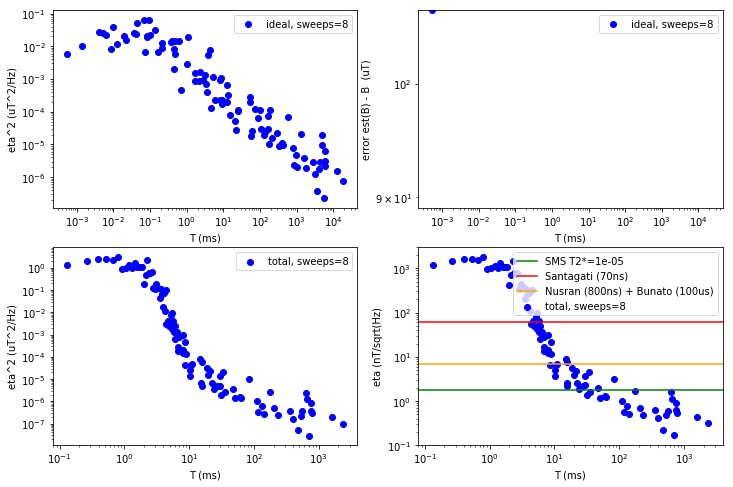

In [348]:
#plot_example_sensitivity()

max_epochs = 100
n_mc = 10
t2star = 10e-6

noise_mode = None

fig, axs = plt.subplots(2,2, figsize=(12,8))
ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]


n_sweeps = 1
taus, t_totals, dbs, errs = est_dB_vs_t(max_epochs, n_sweeps, n_mc=n_mc)
etas = calc_sensitivitiy(dbs, taus)   # uT/sqrt(Hz)
etas_total = calc_sensitivitiy(dbs, t_totals)
plot_eta_sq_vs_t(taus, etas, ax=ax1, label='ideal, sweeps={}'.format(n_sweeps), color='blue')
plot_err_vs_t(taus, errs, ax=ax2, label='ideal, sweeps={}'.format(n_sweeps), color='blue')
ax2.set_ylim([np.min(errs),np.max(errs)])

plot_eta_sq_vs_t(t_totals, etas_total, ax=ax3, label='total, sweeps={}'.format(n_sweeps), color='blue'),

# eta plot
plot_eta_vs_t(t_totals, np.asarray(etas_total)*1e3, ax=ax4, label='total, sweeps={}'.format(n_sweeps), color='blue')
plot_hor_line(1e3*calc_stdmes_sensitivity(t2star/2, t2star/2+2e-6, t2star), label='SMS T2*={}'.format(t2star), ax=ax4)
plot_hor_line(60, label='Santagati (70ns)'.format(t2star), ax=ax4, color='red')
plot_hor_line(7, label='Nusran (800ns) + Bunato (100us)'.format(t2star), ax=ax4, color='orange')

"""
n_sweeps = 10
taus, t_totals, dbs, errs = est_dB_vs_t(max_epochs, n_sweeps, n_mc=n_mc)
etas = calc_sensitivitiy(dbs, taus)   # uT/sqrt(Hz)
plot_eta_sq_vs_t(taus, etas, ax=ax1, color='green', label='sweeps={}'.format(n_sweeps))
plot_err_vs_t(taus, errs, ax=ax2, color='green', label='sweeps={}'.format(n_sweeps))
"""
"""
n_sweeps = 1
taus, t_totals, dbs, errs = est_dB_vs_t(max_epochs, n_sweeps, n_mc=n_mc)
etas = calc_sensitivitiy(dbs, taus)   # uT/sqrt(Hz)
plot_eta_sq_vs_t(taus, etas, ax=ax1, color='orange', label='sweeps={}'.format(n_sweeps))
plot_err_vs_t(taus, errs, ax=ax2, color='orange', label='sweeps={}'.format(n_sweeps))
"""
ax2.legend()
ax1.legend()
ax3.legend()
ax4.legend()

print("t_overhead: {}".format(t_overhead))



# Noise

## Precision vs n_sweeps

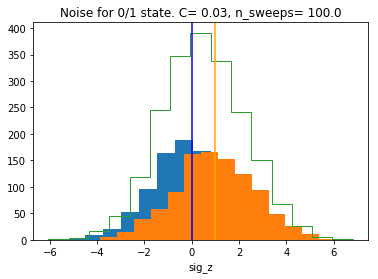

Noise Gauss n_rep=100: precision 4.0% big errors (96/100), [1144.39195002  806.97091707  234.80630745  621.18445786  172.82933546
  156.96583252  335.56028082  107.23787718  209.38254886  538.0825786
   45.23162523  211.22149108  112.49891758  308.34571306  242.4837692
  426.15882313  455.83112711  591.33106623  205.10730976   96.61126615
  209.71850642  273.97448325  910.77644268  385.53698128  605.12133684
  226.79205405  437.1017057    73.49967734   18.3765113   693.07062313
  619.53561423  402.34846648  925.50457192   26.54101144  128.49940554
   95.5465348   428.33152879  584.17798086  452.89466241  486.48975422
  -14.46997166  146.47424492  487.34536275   86.88031545  391.46370505
  804.87913872  382.77784892  550.38235554  903.36551099  538.04941226
 1007.30832326  556.03803474  122.83463589  247.04793713  734.00731872
  765.87553194  621.40868953  292.16881552  641.13215224   36.49461875
  143.67573913  417.07554874   48.93584136  921.8728181   221.90332055
   18.70611119  324.

In [392]:
set_common_params()

# monte carlo params
max_epochs = 100
n_sweeps = 1
n_mc = 100
tolerate_rel_error = 10e-2
        
# Noise
noise_mode = 'Gauss'
noise_c = 0.03
noise_n_rep = 1e2
plot_noise_model()

# precision @ sweeps = fixed
rel_precision, big_errors = estimate_precision(n_mc, max_epochs, tolerate_rel_err=tolerate_rel_error)
#print("dB_list {}, err_list {}, rel_err {}".format(dB_list, err_list, rel_error_list))
print("Noise {} n_rep={}: precision {:.1f}% big errors ({}/{}), {} %".format(noise_mode, int(noise_n_rep), 100*rel_precision,
                                                               len(big_errors), n_mc, 100*big_errors))
# NO NOISE
noise_mode = None
rel_precision, big_errors = estimate_precision(n_mc, max_epochs, tolerate_rel_err=tolerate_rel_error)
print("Noise {} n_rep={}: precision {:.1f}% big errors ({}/{}), {} %".format(noise_mode, int(noise_n_rep), 100*rel_precision,
                                                               len(big_errors), n_mc, 100*big_errors))

# precision vs n_sweeps
rep_list = np.linspace(1e2, 5e3, 10)
noise_mode = 'Gauss'
noise_c = 0.03
precision_list = []
label = '[{}] c= {}, mfl_a= {}, mfl_th= {}'.format(noise_mode, noise_c, mfl_res_a, mfl_res_th)
for n_rep in rep_list:
    noise_n_rep = n_rep
    rel_precision, _ = estimate_precision(n_mc, max_epochs, tolerate_rel_err=tolerate_rel_error)
    precision_list.append(rel_precision)

noise_mode = None
#mfl_res_a = 0.85
#mfl_res_th = 0.4
precision_list_2 = []
label_2 = '[{}] c= {}, mfl_a= {}, mfl_th= {}'.format(noise_mode, noise_c, mfl_res_a, mfl_res_th)
for n_rep in rep_list:
    noise_n_rep = n_rep
    rel_precision, _ = estimate_precision(n_mc, max_epochs, tolerate_rel_err=tolerate_rel_error)
    precision_list_2.append(rel_precision)
    
print("Done")
    

Text(0, 0.5, 'rel precision')

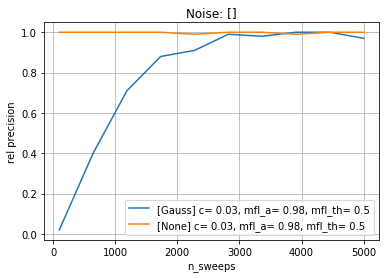

In [394]:
plt.plot(rep_list, precision_list, label=label)
plt.title('Noise: []')
plt.plot(rep_list, precision_list_2, label=label_2)
plt.legend()
plt.grid()

plt.xlabel('n_sweeps')
plt.ylabel('rel precision')

## Precision vs freq_max

In [452]:
set_common_params()

# monte carlo params
max_epochs = 100
n_sweeps = 1
n_mc = 25
tolerate_rel_error = 10e-2
       
# Noise
noise_mode = 'Gauss'
noise_c = 0.03
noise_n_rep = 1e3
#plot_noise_model()

# precision vs f_max
f_max_mhz_list = np.linspace(true_omega, 20*true_omega, 12)/(2.*np.pi)
precision_list = []
label = '[{}] c= {}, mfl_a= {}, mfl_th= {}'.format(noise_mode, noise_c, mfl_res_a, mfl_res_th)
for f in f_max_mhz_list:
    freq_max = f*2*np.pi
    rel_precision, _ = estimate_precision(n_mc, max_epochs)
    precision_list.append(rel_precision)
    
print("Done")

Done


Text(0, 0.5, 'rel precision')

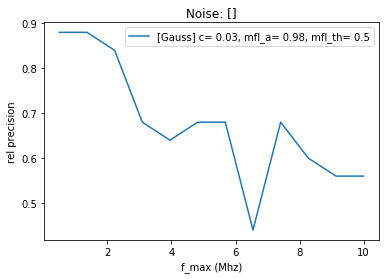

In [453]:
plt.plot(f_max_mhz_list, precision_list, label=label)
plt.title('Noise: []')
plt.legend()

plt.xlabel('f_max (Mhz)')
plt.ylabel('rel precision')

## Precision vs f, f_max @ n_rep=const

In [446]:
set_common_params()

max_epochs = 100
n_mc = 20
tolerate_rel_error = 10e-2

noise_mode = 'Gauss'
noise_c = 0.03
noise_n_rep = 1e3
t2star_s = 0

freq_max_mhz_list = np.linspace(0.2, 10, 10)
omega_true_mhz_list = np.linspace(0.1, 2.5, 10)

prec_array = np.zeros([len(freq_max_mhz_list), len(omega_true_mhz_list)])

for i, f_max in enumerate(freq_max_mhz_list):
    for j, omega in enumerate(omega_true_mhz_list):
        
        true_omega = omega * 2*np.pi
        freq_max = f_max * 2*np.pi
        
        #print(get_params())
        
        try:
            rel_precision, _ = estimate_precision(n_mc, max_epochs)
        except NameError: # by not defined ApproximationWarning
            rel_precision = 0
        prec_array[i, j] = rel_precision

KeyboardInterrupt: 

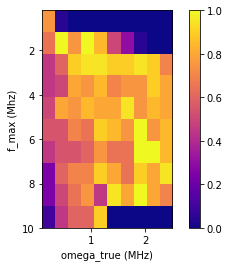

(0, 1)

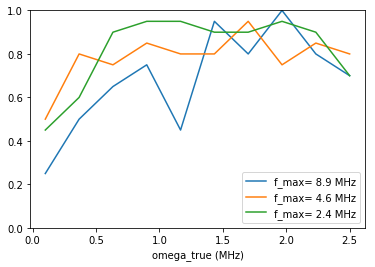

In [448]:
# todo: double check extend / x,y axis!
aspect = 0.1*(freq_max_mhz_list[-1] - freq_max_mhz_list[0])/(omega_true_mhz_list[-1] - omega_true_mhz_list[0])
plt.imshow(prec_array, extent=[omega_true_mhz_list[0], omega_true_mhz_list[-1], freq_max_mhz_list[-1], freq_max_mhz_list[0]], aspect=aspect, cmap='plasma', vmax=1, vmin=0.0)
plt.colorbar()
plt.xlabel("omega_true (MHz)")
plt.ylabel("f_max (Mhz)")
plt.show()

plt.figure()
i_max = -2
plt.plot(omega_true_mhz_list, prec_array[i_max,:], label="f_max= {:.1f} MHz".format(freq_max_mhz_list[i_max]))
#i_max = -4
#plt.plot(omega_true_mhz_list, prec_array[i_max,:], label="f_max= {:.1f} MHz".format(freq_max_mhz_list[i_max]))
i_max = -6
plt.plot(omega_true_mhz_list, prec_array[i_max,:], label="f_max= {:.1f} MHz".format(freq_max_mhz_list[i_max]))
i_max = -8
plt.plot(omega_true_mhz_list, prec_array[i_max,:], label="f_max= {:.1f} MHz".format(freq_max_mhz_list[i_max]))
plt.xlabel("omega_true (MHz)")
plt.legend()
axes = plt.gca()
axes.set_ylim([0,1])


## Precision vs mfl_a, mfl_th @ n_rep=const

In [138]:
set_common_params()

max_epochs = 100
n_sweeps = 1
n_mc = 200
tolerate_rel_error = 10e-2

noise_mode = 'Gauss'
noise_c = 0.03
noise_n_rep = 1e3

a_list = np.linspace(0.9, 0.91, 20)
th_list = np.linspace(0.7, 0.71, 20)

prec_array = np.zeros([len(a_list), len(th_list)])

for i, a in enumerate(a_list):
    for j, th in enumerate(th_list):
        
        mfl_res_a = a
        mfl_res_th = th
        
        try:
            rel_precision, _ = estimate_precision(n_mc, max_epochs)
        except NameError: # by not defined ApproximationWarning
            rel_precision = 0
        prec_array[i, j] = rel_precision
        
        


KeyboardInterrupt: 

Text(0, 0.5, 'mfl_resampling_a')

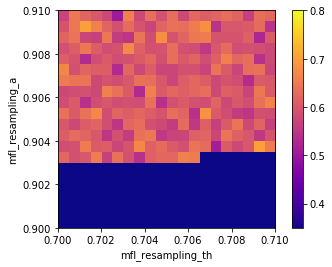

In [140]:
#prec_array
# todo: double check extend / x,y axis!
aspect = 1/(a_list[-1] - a_list[0])/(th_list[-1] - th_list[0])
plt.imshow(prec_array, extent=[th_list[0], th_list[-1], a_list[0], a_list[-1]], aspect=1, cmap='plasma', vmax=0.8, vmin=0.35)
plt.colorbar()
plt.xlabel("mfl_resampling_th")
plt.ylabel("mfl_resampling_a")


# Profile with cProfile

In [ ]:
import cProfile
cProfile.run('run_estimation()', 'profile_data')
import pstats
p = pstats.Stats('profile_data')
p.strip_dirs().sort_stats('cumtime').print_stats()


In [25]:
# Profile with line_profiler
%lprun -f 'run_estimation()'

ERROR:root:Line magic function `%lprun` not found.


In [59]:
print([el[0][0] for el in track_cov])

[17.07611884033822, 13.249580505014727, 12.339597483243331, 12.984399607527504, 8.158266110562193, 6.2281634943274184, 6.726487211507631, 8.564977878675485, 13.55994277132737, 13.311815534021568, 15.573371350073858, 15.754533576569587, 15.837485666062232, 15.726994929095762, 14.254352438035522, 14.395552886198828, 14.113545856361661, 13.817846033489209, 13.04680764999155, 12.60966765734167, 12.525834481732478, 11.445324314649744, 8.627661578750393, 9.183857419670753, 5.487120363434834, 3.6459408905444093, 3.5784061470777107, 3.2043710241226786, 2.5230312715456575, 2.2215292867938734, 2.4099290941852196, 2.0422560985203173, 1.2216004683696857, 1.1007305185709826, 1.0773851781552628, 0.9925201153209505, 0.76303542053975, 0.7240153347161595, 1.4577294671594816, 1.5643225588089174, 1.3215860577944611, 1.4203935215021866, 1.1706668112360024, 1.1720554415801994, 1.190363673425998, 1.2406406996301453, 1.2002734278061742, 1.2543283902020452, 1.2305476462241662, 1.146890866310617, 1.08846808846

[9.42978085] [[0.00235536]]


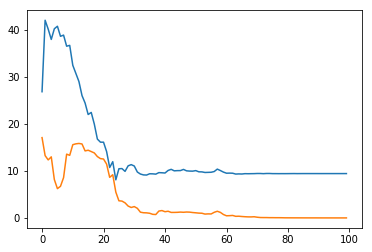